# Semantic image search
In this notebook we will try to find the semanting image search, we will focus on feature extraction and semantic similarity search.

## Overview of semantic image search
Semantic image search is the task of ranking a collection of images based on their similarity to a given query image. While there are various ways to approach this problem, the general workflow of our solution is both intuitive and effective, involving the following steps:


![image info](./images/semantic_search.png)

The process begins with extracting feature maps from each image in the dataset using a pre-trained convolutional neural network (CNN) OriginalSizeCNN. These feature maps serve as a compact representation of each image’s visual content. Once we have these feature maps, we calculate the similarity between images by measuring the distance between their feature vectors. This process is repeated for every image pair in the dataset, resulting in a list of similarity scores. By sorting these scores in descending order, we can rank images by how similar they are to the query image.

In essence, a well-trained model should produce feature maps that capture semantic similarity—meaning the feature maps of similar images are closer together in vector space, while dissimilar images are farther apart. The ultimate goal is for the model to learn representations that meaningfully reflect how humans perceive image similarity.

## Set up paths and imports

In [8]:
import os

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

if not os.path.exists("./notebooks"):
    %cd ..

import src.model
from PIL import Image
from src.data_processing import load_mean_std
from src.config import DATASET_DIR
from src.dataset_analysis import plot_spectrogram
from src.training import process_predictions_and_features
from src.dataset import prepare_dataset_loader


## 0. Set device and extact the dataset

In [9]:
import shutil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def copy_images_with_keywords(src_dir, dest_dir, keywords):
    if os.path.exists(dest_dir):
        return
    
    os.makedirs(dest_dir)

    for filename in os.listdir(src_dir):
        if any(keyword.lower() in filename.lower() for keyword in keywords): 
            src_path = os.path.join(src_dir, filename)
            dest_path = os.path.join(dest_dir, filename)
            
            if os.path.isfile(src_path) and filename.lower().endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp')):
                shutil.copy(src_path, dest_path)

allowed_directories=['ipadflat_confroom1', 'ipadflat_office1', 'ipad_balcony1', 'ipad_bedroom1', 'ipad_confroom1']
copy_images_with_keywords("datasets/test", "feature_datasets", allowed_directories)

## 1. Load Images from dataset
In the CNN visual interpretation notebook, we used only a subset of the dataset for analysis. While the models were trained on the complete dataset, performing feature extraction on the entire dataset required excessive storage. To address this, we reduced the dataset to include only the following files: `ipadflat_confroom1`, `ipadflat_office1`, `ipad_balcony1`, `ipad_bedroom1`, and `ipad_confroom1`.

In [10]:
def load_images(directory, transform):
    images = []
    image_files = sorted(os.listdir(directory))  
    for filename in image_files:
        filepath = os.path.join(directory, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = Image.open(filepath).convert("L")
            image = transform(image)
            images.append(image)
    return images, image_files

mean, std = load_mean_std(f"{DATASET_DIR}/scaling_params.json")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
feature_dataset_directory = "feature_datasets"
images, image_files = load_images(feature_dataset_directory, transform)

## 2. Load OriginalSizeCNN model
In this section, we present the visual interpretation of our most successful model, the OriginalSizeCNN. This model comprises three convolutional layers, from which we aim to extract and analyze feature maps.

Feature maps, the outputs of these convolutional layers, represent the spatial patterns and features detected by the network from the input data. These maps capture various levels of detail, such as edges, textures, and more complex patterns as the data progresses through the layers. By visualizing these feature maps, we can better understand how the model identifies and processes important features in the input, offering valuable insights into its learning and decision-making process.

In [11]:

name = "OriginalSizeCNN"
model = src.model.OriginalSizeCNN()
model_path = f"./models/{name}.pth"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device(device)))
model.device = device
model = model.to(device)

## 3. Plot Sample Image
In our dataset, we are working with audio clips. To process these audio signals in a Convolutional Neural Network (CNN), we first convert them into spectrograms, which represent the frequency content of the audio over time. Spectrograms transform audio data into a visual format, making it suitable for CNNs to analyze.

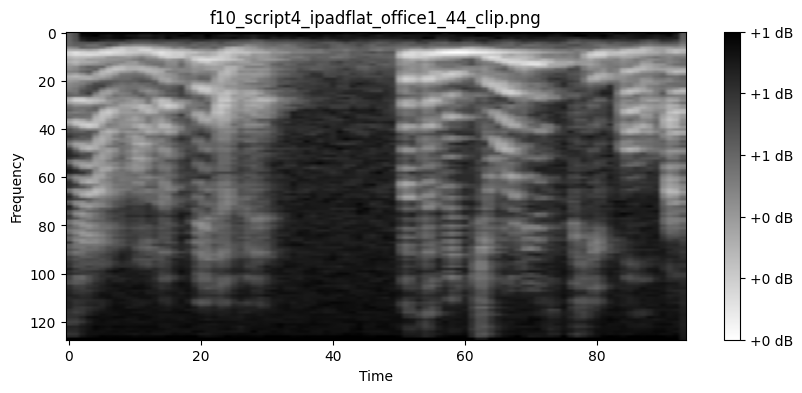

In [12]:
imageId = 244
sample_image = images[imageId]
plot_spectrogram(plt.imread(f"{feature_dataset_directory}/{image_files[imageId]}"), image_files[imageId])

## 4. Get feture map for first Convolutional Layer
To extract feature maps from specific layers, we will create models that terminate at the desired layer. For instance, to obtain feature maps from the first convolutional layer (conv1), we construct a model that outputs the activations of that layer. Using these specialized models, we can feed an input (e.g., sample_image) and extract the corresponding feature maps.

In [13]:
c1_layer = src.model.ModelWithLayerOutput(model,"conv1")
c1_layer.device = device
c1_feature_map = c1_layer(sample_image).detach().numpy()

c1_feature_map.shape

(16, 128, 94)

## 5. Visualize feature map
We see that the feature map generated from the output of the first convolutional layer of OriganSizeCNN conforms to the shape of (16, 128, 94). The first convolutional layer of OrginalCNN applies 16 3x3 filters resulting in 16 channels. We can visualize each of these activation maps to gain intuition for the types of things that the learned filters are detecting as signal at this layer. 

In the example below, we see that some channels are picking up on edges changes, while others focus on background and foreground shading/color. This is consistent with our expectation as this first layer should be honing in on very specific details in the image.


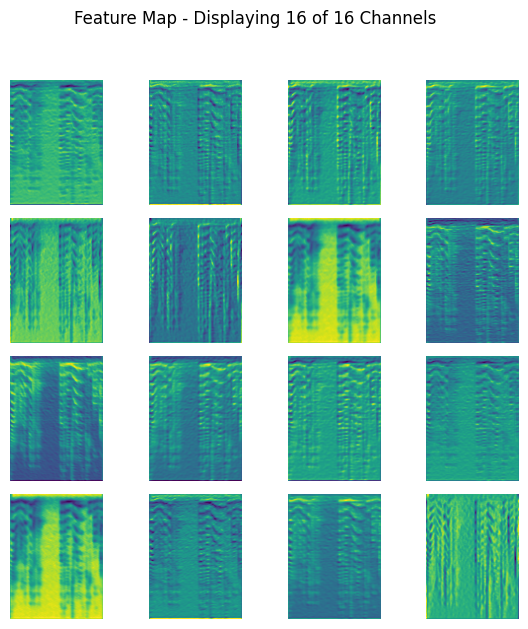

In [14]:
def plot_feature_map(feature_map, max_grid):
    
    fig, ax = plt.subplots(max_grid, max_grid, figsize=(7,7))
    channel_idx = 0
    
    for i in range(max_grid):
        for j in range(max_grid):
            ax[i][j].imshow(feature_map[channel_idx,:,:])
            ax[i][j].axis('off')
            
            channel_idx += 1
            
    fig.suptitle(f'Feature Map - Displaying {max_grid**2} of {feature_map.shape[0]} Channels')
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

plot_feature_map(c1_feature_map, 4)

## 6. Feature maps from seconds layer

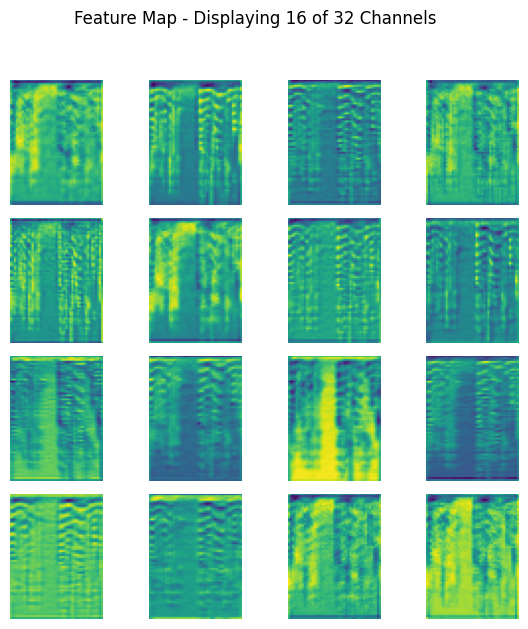

In [15]:
c2_layer = src.model.ModelWithLayerOutput(model,"conv2")
c2_layer.device = device
c2_feature_map = c2_layer(sample_image).detach().numpy()
c2_feature_map.shape
plot_feature_map(c2_feature_map, 4)


## 7. Compare feature maps from third layer
On the third convolutional layer of our model we will be extracting 64 channels. We expect them to focus on more semantically important features of our images, unfortunetly as we are working with spectrograms it is not intuitive for humans on what does the model focus.


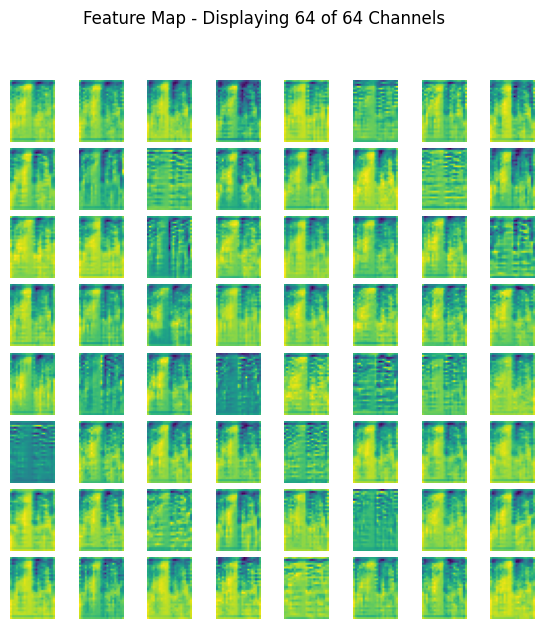

In [16]:
c3_layer = src.model.ModelWithLayerOutput(model,"conv3")
c3_layer.device = device
c3_feature_map = c3_layer(sample_image).detach().numpy()
c3_feature_map.shape
plot_feature_map(c3_feature_map, 8)


# Similarity Search

Now that we understand how to extract semantically meaningful features using a pretrained CNN, we can explore leveraging these features for scalable search. Facebook AI Similarity Search (FAISS) is a powerful and highly optimized library designed for this purpose. It enables efficient comparisons of a query record (e.g., a feature vector) against a stored database of feature vectors to retrieve the most similar ones.

FAISS uses various metrics to calculate the "similarity" between vectors, with one of the simplest being proximity in Euclidean space—similar vectors are those that are closer together in this space. For more information on FAISS, feel free to explore this article.

To demonstrate FAISS in action, we'll start by extracting feature maps from the first and third convolutional layers (c1_layer and c3_layer) for every image in our reduced dataset. Each feature map's vectors will then be added to its own FAISS index, enabling us to perform similarity searches efficiently. Finally, we’ll conduct similarity searches using these indices and visualize the comparative search results from the two feature maps for a given input image.

## 8. Load feature maps for all images

In [17]:
batch_size = 10

image_loader = prepare_dataset_loader(feature_dataset_directory, transform, batch_size)
c3_layer.device = "cpu"
c3_layer = c3_layer.to("cpu")
preds, feature_maps = process_predictions_and_features(c1_layer, image_loader)
preds_c3, feature_maps_c3 = process_predictions_and_features(c3_layer, image_loader)





## 9. Create faiss indexes for feature maps.

In [ ]:
import faiss
import numpy as np
feature_maps = np.vstack(feature_maps)
feature_maps_c3 = np.vstack(feature_maps_c3)

indicies = {}
features = {'c1_layer': feature_maps,
            'c3_layer': feature_maps_c3}

for name, feature_map in features.items():
    feature_dim = feature_map.shape[1]
    index = faiss.IndexFlatL2(feature_dim)
    index.add(feature_map)
    
    indicies[name] = index

## 10. Define functions for getting n similar images from dataset using FAISS.
This function compares a given query image against feature maps to find the most similar images. It then visualizes the top `k` most similar images for each convolutional layer's feature map.

In [ ]:
import textwrap
def wrap_title(title, width=25):
    return "\n".join(textwrap.wrap(title, width=width))
    
def get_similar(index, query_vec, k):
    distances, indices = index.search(query_vec, k)
    return distances, indices

# Define function to visually compare top similar results for a given query image against feature maps
def plot_n_similar(faiss_indicies, image_holder, image_files, feature_maps, query_idx, k):
    
    # Get similar vectors for each conv layer
    sim_indicies = {}
    for layer in faiss_indicies.keys():
        dist, indic = get_similar(faiss_indicies[layer],
                                  feature_maps[layer][query_idx:query_idx+1], k)
        
        sim_indicies[layer] = indic
    
    # Plot query image
    plt.title(f'Query Image - {image_files[query_idx]}' )
    query_img = image_holder[query_idx]
    plt.imshow(query_img.squeeze(0), cmap="gray")

    
    # Plot k most similar images for each layers feature map
    fig, ax = plt.subplots(2, k)
    
    i = 0
    for layer, indic in sim_indicies.items():
        indic = indic.ravel()
        for j in range(len(indic)):
            ax[i][j].axis('off')
            ax[i][j].imshow(image_holder[indic[j]].squeeze(0),cmap="gray")
            ax[i][j].set_title(wrap_title(f'Rank {j+1} - {layer} - {image_files[indic[j]]}'), fontsize=5)
        i += 1
        
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(f'Top {k} Most Similar Images by Feature Map')
    plt.show()

## 11. Plot sample results
Using the similarity plotting function, we can easily compare the efficacy of each convolutional layer's feature map in extracting semantic meaning from an image. In the example below (query_idx = 200), we see that the first layer properly identifies person but returns wrong image. On the other hand the third layer returned exactly the image we querried as the fourth most similar result.

In [ ]:
plot_n_similar(faiss_indicies=indicies,
               image_holder=images,
               image_files=image_files,
               feature_maps=features,
               query_idx=200,
               k=5)